In [1]:
import numpy as np
import os
ecc=1.1;M=70;impact=60;ncore=8
arrlen=50

q=1;
if M-40>=2.8:
    masses=np.linspace(M-40,M+40,arrlen)
else:
    masses=np.linspace(2.8,M+40,arrlen)
    
if impact-30>=40:
    impacts = np.linspace(impact-30,impact+30,arrlen)
else:
    impacts = np.linspace(40,impact+30,arrlen)

In [2]:
masses=np.linspace(2.8,150,arrlen)
impacts=np.linspace(40,150,arrlen)

In [3]:
os.chdir('../gwhyp/')
import pycbc.waveform
from pycbc.waveform import td_approximants
import os
import matplotlib.pyplot as plt
import pylab
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from constants import *
from tqdm import tqdm
from pycbc.waveform import get_td_waveform
from multiprocess import Pool
import pickle
from hyp_td_waveform_v2 import get_hyp_waveform
os.chdir('../mb_contour/')

In [4]:
fn='file_e_'+str(ecc)+'_ref_M'+str(M)+'b_'+str(impact)+'_hc2.pkl'
os.remove(fn) if os.path.exists(fn) else None  #here fn - filename or filepath

In [5]:
approximant = 'HyperbolicTD'

f_lower = 10
delta_t = 1./1024
inc=pi/3
distance=1e6*pc
order=3
f_lower = 10
matchfactor=0.99

hp,hc=get_hyp_waveform(M,q,ecc, impact,  delta_t, inc, distance, order)

psd = aLIGOZeroDetHighPower(len(hc) // 2 + 1, 1.0 / hc.duration, f_lower)

masses,impacts=np.meshgrid(masses,impacts)

def cal_match_eb(M,b):
    
#     hp2,hc2=get_td_waveform(approximant=approximant,
#                              mass1=M/2, mass2=M/2,
#                              delta_t=delta_t,
#                              hyp_eccentricity = e,
#                              b = b,f_lower = f_lower)
    hp2,hc2=get_hyp_waveform(M,q,ecc, b,  delta_t, inc, distance, order)
    hc2 = hc2[:len(hc)] if len(hc) < len(hc2) else hc2
    hc2.resize(len(hc))

    m, idx = match(hc, hc2, psd=psd, low_frequency_cutoff=f_lower)
    return m

arr2=np.zeros((arrlen,arrlen))

peakfile = open('file_e_'+str(ecc)+'_ref_M'+str(M)+'b_'+str(impact)+'_hc2.pkl', 'ab')


if __name__ == "__main__":

    pool = Pool(ncore)
    results = pool.map(lambda t : cal_match_eb(t[0],t[1]), 
                       [(masses[i][j],impacts[i][j])
                        for i in range(arrlen) for j in range(arrlen)] )

    pickle.dump(np.array(results).reshape((arrlen,arrlen)),peakfile)
    peakfile.close()

arr2 = pickle.load(open('file_e_'+str(ecc)+'_ref_M'+str(M)+'b_'+str(impact)+'_hc2.pkl', 'rb'))

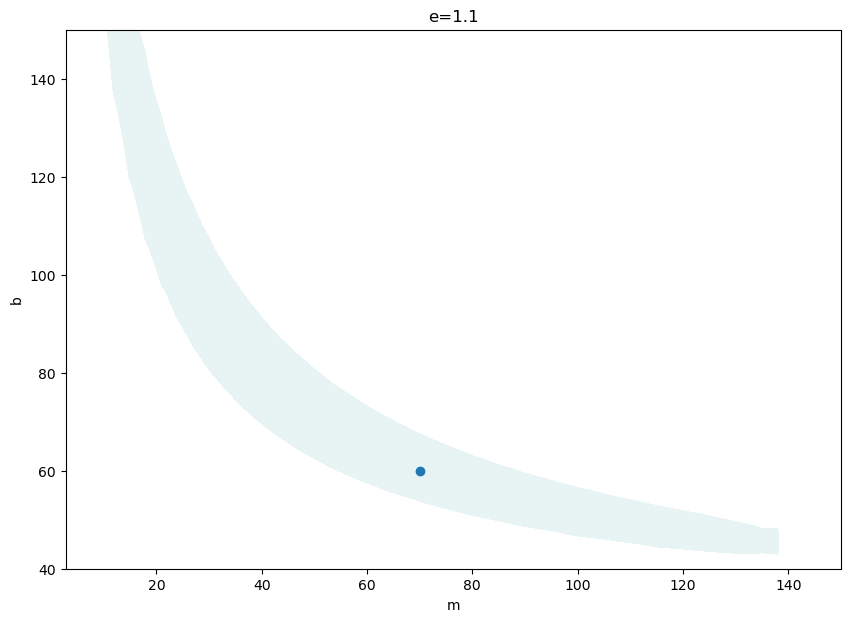

In [6]:
fig1=plt.figure(figsize=(10,7))
plt.title('e='+str(ecc))
plt.contourf(masses, impacts, arr2,[0.97,1],alpha=0.1)
plt.scatter(M,impact)
plt.xlabel('m')
plt.ylabel('b')
plt.savefig('file_e_'+str(ecc)+'_ref_M'+str(M)+'b_'+str(impact)+'_hc2.png',dpi=300)
plt.show()